In [1]:
import pandas as pd
import numpy as np
import datetime
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('master.csv')

In [3]:
Counter(df.generation)

Counter({'Generation X': 6408,
         'Silent': 6364,
         'G.I. Generation': 2744,
         'Boomers': 4990,
         'Millenials': 5844,
         'Generation Z': 1470})

In [4]:
mean_df = df.groupby('country').mean().reset_index()

In [5]:
high_countries = mean_df[mean_df['suicides/100k pop'] > 30.0].country.values

In [6]:
high_df = df[df.country.isin(high_countries)]

In [7]:
low_countries = mean_df[mean_df['suicides/100k pop'] < 10.0].country.values

In [8]:
low_df = df[df.country.isin(low_countries)]

In [9]:
drop_list = ['country-year', 'year', 'suicides_no', ' gdp_for_year ($) ', 'population']

In [10]:
df.fillna(0, inplace=True)

In [11]:
df_ml = df.drop(drop_list, axis = 1)

In [12]:
df_ml = pd.get_dummies(df_ml)

In [13]:
df_ml.head()

,suicides/100k pop,HDI for year,gdp_per_capita ($),country_Albania,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Aruba,country_Australia,country_Austria,...,age_35-54 years,age_5-14 years,age_55-74 years,age_75+ years,generation_Boomers,generation_G.I. Generation,generation_Generation X,generation_Generation Z,generation_Millenials,generation_Silent
0,6.71,0.0,796,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,5.19,0.0,796,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,4.83,0.0,796,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4.59,0.0,796,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,3.28,0.0,796,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [14]:
df_ml['suicides/100k pop'].std()

18.96151101450304

In [15]:
df_ml['suicides/100k pop'].mean()

12.816097411933894

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_df, test_df = train_test_split(df_ml, train_size = 0.66, stratify = df.country.values)

C:\Users\grech\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
y_train = train_df.pop('suicides/100k pop')
y_test = test_df.pop('suicides/100k pop')

X_train = train_df.values 
X_test = test_df.values

In [19]:
from sklearn.linear_model import Lasso

In [20]:
lm = Lasso().fit(X_train, y_train)

In [21]:
y_pred = lm.predict(X_test)

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
np.sqrt(mean_squared_error(y_test, y_pred))

16.72493768996747

In [24]:
weights = lm.coef_

In [25]:
def get_pos_neg_features(weights, encoded_col_names):
    indexed_weights = list(zip(range(len(weights)), weights))    
    sorted_weights = sorted(indexed_weights, key=lambda x: x[1])
    
    pos = []
    for i in sorted_weights[-10:]:
        pos.append(i[0])  
        
    neg = []
    for i in sorted_weights[:10]:
        neg.append(i[0])  
            
    pos_features = encoded_col_names[pos]
    neg_features = encoded_col_names[neg]
    
    print('To 10 Positive Features:')
    print(pos_features)
    print()
    
    print('To 10 Negative Features:')
    print(neg_features)
    
    return pos_features, neg_features

In [26]:
pos_features, neg_features = get_pos_neg_features(weights, train_df.columns)

To 10 Positive Features:
Index(['age_15-24 years', 'age_25-34 years', 'age_35-54 years',
       'age_55-74 years', 'generation_Boomers', 'generation_G.I. Generation',
       'generation_Generation X', 'generation_Generation Z',
       'generation_Silent', 'age_75+ years'],
      dtype='object')

To 10 Negative Features:
Index(['sex_female', 'age_5-14 years', 'generation_Millenials',
       'gdp_per_capita ($)', 'HDI for year', 'country_Albania',
       'country_Antigua and Barbuda', 'country_Argentina', 'country_Armenia',
       'country_Aruba'],
      dtype='object')


In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
rf = RandomForestRegressor(n_estimators=300).fit(X_train, y_train)

In [29]:
y_pred = rf.predict(X_test)

In [30]:
np.sqrt(mean_squared_error(y_test, y_pred))

6.454136477585389

In [31]:
weights = rf.feature_importances_

In [32]:
indexed_weights = list(zip(train_df.columns, weights))    
sorted_weights = sorted(indexed_weights, key=lambda x: x[1], reverse = True)  

In [40]:
sorted_weights[:20]

[('age_5-14 years', 0.11077789866365606),
 ('gdp_per_capita ($)', 0.10331896063981082),
 ('sex_male', 0.0808016107860289),
 ('sex_female', 0.07379397481712435),
 ('age_75+ years', 0.05898921832859316),
 ('country_Lithuania', 0.041031375796617),
 ('country_Hungary', 0.033144848292415284),
 ('country_Russian Federation', 0.03269373870988868),
 ('country_Republic of Korea', 0.021829193611847212),
 ('country_Kazakhstan', 0.0215564390960373),
 ('country_Belarus', 0.021388107874227118),
 ('age_15-24 years', 0.019116624885504908),
 ('country_Latvia', 0.01874199542973241),
 ('country_Ukraine', 0.017553937056093424),
 ('country_Slovenia', 0.016816530100953842),
 ('country_Austria', 0.01610028565346106),
 ('country_Estonia', 0.015132815534845016),
 ('country_Bulgaria', 0.013310288094240641),
 ('country_Sri Lanka', 0.013067573713181685),
 ('country_Croatia', 0.012466018794944968)]

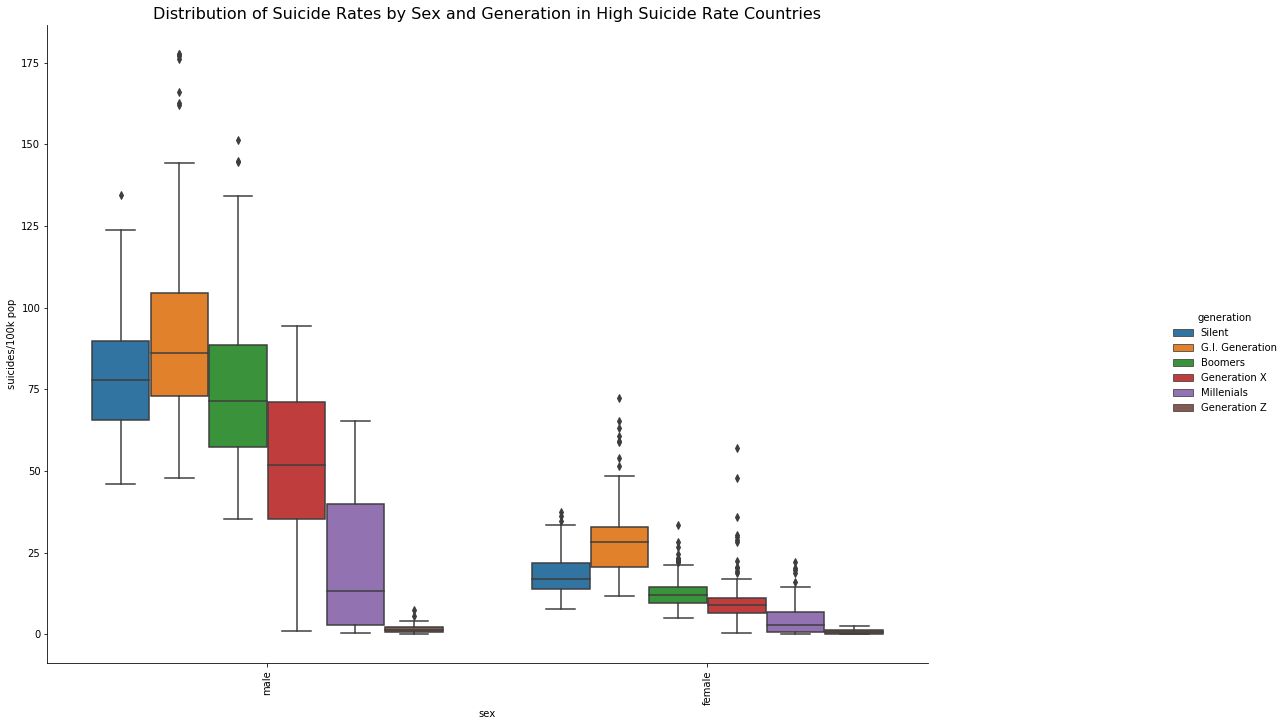

In [44]:
sns.catplot(x = 'sex', y = 'suicides/100k pop', data = high_df, hue = 'generation', kind = 'box')
#order=["G.I. Generation", "Silent", 'Boomers', 'Generation X', 'Millenials', 'Generation Z']
plt.xticks(rotation=90)
plt.title('Distribution of Suicide Rates by Sex and Generation in High Suicide Rate Countries', fontsize=16)
fig = plt.gcf()
fig.set_size_inches(20, 10.5)

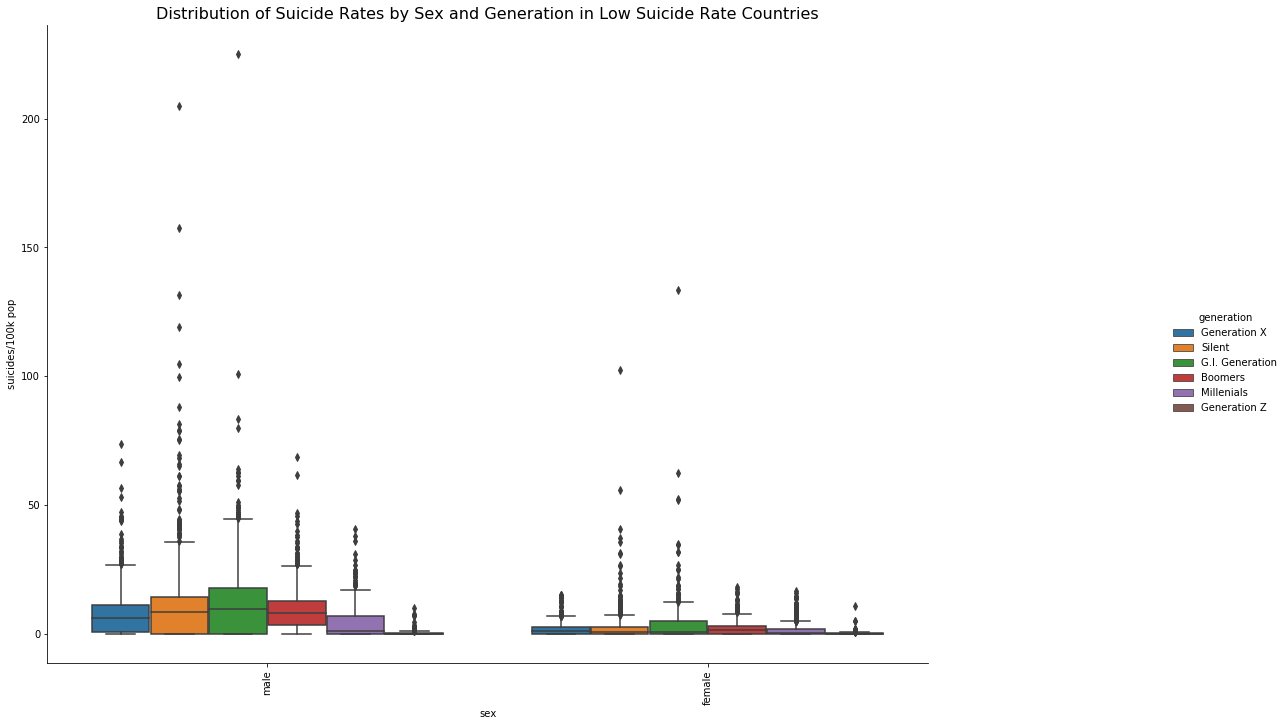

In [45]:
sns.catplot(x = 'sex', y = 'suicides/100k pop', data = low_df, hue = 'generation', kind = 'box')
#order=["G.I. Generation", "Silent", 'Boomers', 'Generation X', 'Millenials', 'Generation Z']
plt.xticks(rotation=90)
plt.title('Distribution of Suicide Rates by Sex and Generation in Low Suicide Rate Countries', fontsize=16)
fig = plt.gcf()
fig.set_size_inches(20, 10.5)

In [41]:
slavic_countries = ['Lithuania', 'Russian Federation', 'Kazakhstan', 'Ukraine', 'Bulgaria']

In [42]:
slavic_df = df[df.country.isin(slavic_countries)]

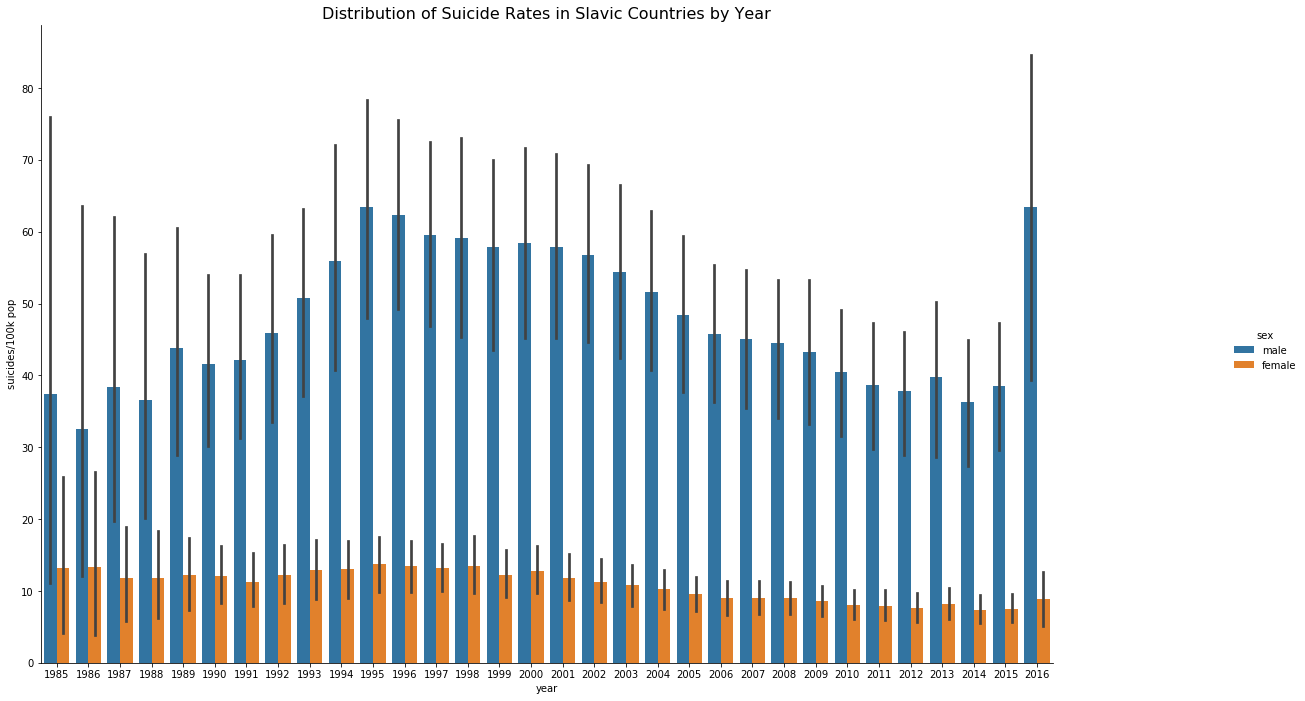

In [43]:
sns.catplot(x="year", y="suicides/100k pop", kind="bar", hue='sex', data=slavic_df);
plt.title('Distribution of Suicide Rates in Slavic Countries by Year', fontsize=16)
fig = plt.gcf()
fig.set_size_inches(20, 10.5)